## Simple hyperbolic operations

Computations derived from ["Hyperbolic Image Embeddings" by *Valentin Khrulkov, Leyla Mirvakhabova, Evgeniya Ustinova,
Ivan Oseledets Victor Lempitsky*](https://arxiv.org/pdf/1904.02239.pdf) v1

$$\renewcommand{\vec}[1]{{\bf #1} }$$

## Pure hyperbolic (no c) vector addition
$$d_\mathbb{D}(\vec{x}, \vec{y}) = \operatorname{arccosh}\left(1+2
\frac
    {\|\vec{x}-\vec{y}\|^2}
    {(1-\|\vec{x}\|^2)(1-\|\vec{y}\|^2)}
    \right)$$

In [184]:
import numpy as np

def norm(x):
    if np.iterable(x):
        return np.linalg.norm(x, axis=-1)
    else:
        return np.abs(x)

def norm_sq(x):
    return norm(x)**2

def d_hyperbolic(x, y):
    return np.arccosh(1 + 2 * (norm_sq(x - y) / ((1 - norm_sq(x)) * (1 - norm_sq(y)))))

In [195]:
x = np.array([0.5, 0.2])
y = np.array([0.3, -0.4])

d_hyperbolic(x, y)

1.5678231619693916

## Hyperbolic Mobius addition
$$\vec{x} \oplus_c \vec{y} := \frac{\left(1 + 2c \langle \vec{x}, \vec{y} \rangle + c \|\vec{y} \|^2\right)\vec{x} + \left(1-c\| \vec{x} \|^2\right)\vec{y}}
{1+2c\langle \vec{x},\vec{y} \rangle + c^2\|\vec{x}\|^2\|\vec{y}\|^2}$$

In [196]:
def mobius_add_c(x, y, c):
    num = (1 + 2 * c * np.dot(x, y.T) + c * norm_sq(y)) * x + (1 - c * norm_sq(x)) * y
    den = 1 + 2 * c * np.dot(x, y.T) + c ** 2 * norm_sq(x) * norm_sq(y)
    return num / den

In [197]:
mobius_add_c(x, y, c=0.05)

array([ 0.79965746, -0.18894315])

## Hyperbolic distance
$$d_c(\vec{x}, \vec{y}) := \frac{2}{\sqrt{c}} \operatorname{arctanh}\left(\sqrt{c}\|-\vec{x}\oplus_c\vec{y}\|\right)$$

In [198]:
def distance_c(x, y, c):
    cs = np.sqrt(c)
    return 2 / cs * np.arctanh(cs * np.linalg.norm(mobius_add_c(-x, y, c), axis=-1))

In [199]:
distance_c(x, y, c=1.0)

1.5678231619693914

## Hyperbolic exponential map
$$\lambda_\vec{x}^c = \frac{2}{1-c\|\vec{x}\|^2}$$
$$\exp_x^c(\vec{v}) := \vec{x} \oplus_c \left( \operatorname{tanh} 
                                                \left( \sqrt{c} \frac{\lambda_x^c \|\vec{v}\|}{2} \right)        
                                                \frac{\vec{v}}{\sqrt{c}\| \vec{v} \|} \right)$$
                                                               

In [200]:
def lambda_c(x, c):
    return 2 / (1 - c * norm_sq(x))

In [201]:
lambda_c(x, c=0.05)

2.0294266869609334

In [202]:
def exp_c(x, v, c):
    cs = np.sqrt(c)    
    norm_v = norm(v)
    l = lambda_c(x, c)
    return mobius_add_c(x, np.tanh(cs * l * norm_v / 2.0) * v / (cs * norm_v), c=c)

In [203]:
exp_c(x, y, c=0.05)

array([ 0.80280977, -0.1929258 ])

In [204]:
exp_c(x, 0.1, c=0.05)

array([0.59972979, 0.29988087])

## Hyperbolic logarithmic map
$$\log_\vec{x}^c := \frac{2}{\sqrt{c}\lambda^c_\vec{x}}
\operatorname{arctanh}\left(\sqrt{c}\|-\vec{x} \oplus_c \vec{y}\|\right)
\frac{-\vec{x}\oplus_c\vec{y}}
{\|-\vec{x}\oplus_c\vec{y}}
$$

In [205]:
def log_c(x, y, c):
    cs = np.sqrt(c)
    neg_plus = mobius_add(-x, y, c=c)
    norm_plus = np.linalg.norm(neg_plus, axis=-1)
    l = lambda_c(x, c)
    return (2 / (cs * l)) * np.arctanh(cs * norm_plus) * (neg_plus / norm_plus)

In [206]:
log_c(x, y, c=0.05)

array([-0.2068946 , -0.59470957])

## Hyperbolic matrix-vector product

$$M^{\otimes_c}(\vec{x}) := \frac{1}{\sqrt{c}}
\tanh \left(  
    \frac{\|M\vec{x}\|}{\|\vec{x}\|}
    \operatorname{arctanh}(\sqrt{c}\|\vec{x}\|
\right)
    \frac{M\vec{x}}{\|M\vec{x}\|}
$$

In [207]:
def mmul_c(M, x, c):
    cs = np.sqrt(c)
    norm_x = np.linalg.norm(x)
    Mx = M @ x
    norm_mx = np.linalg.norm(Mx)
    return (
        (1 / cs)
        * np.tanh((norm_mx / norm_x) * np.arctanh(cs * norm_x))
        * (Mx / norm_mx)
    )

In [208]:
M = np.array([[1.0, 0.1], [-0.5, 0.3]])
mmul_c(M, x, c=0.05)

array([ 0.51985663, -0.18994761])

## Hyperbolic averaging

$$\operatorname{HypAve}(\vec{x_1}\dots,\vec{x_N}) = \sum_{i=1}^{N} \gamma_i \vec{x}_i / \sum_{i=1}^N\gamma_i$$
$$\gamma_i = \frac{1}{\sqrt{1-c\|\vec{x_i}\|^2}}$$

In [209]:
def gamma_c(x_i, c):
    return 1 / np.sqrt(1 - c * norm_sq(x_i))

In [210]:
gamma_c(x, c=0.05)

1.007329808692499

In [211]:
def hyp_ave(xs, c):
    xs = np.array(xs)
    gammas = gamma_c(xs, c)
    return np.sum(gammas * xs, axis=0) / np.sum(gammas, axis=0)

In [212]:
hyp_ave([x,y], c=0.05)

array([ 0.40020274, -0.09994932])

## Conversion to/from Klein/Poincaré representation

$$\vec{x}_\mathbb{D} = \frac{\vec{x}_\mathbb{K}}
{1 + \sqrt{1- c \| \vec{x}_\mathbb{K}\|^2}}$$

$$\vec{x}_\mathbb{K} = \frac{2\vec{x}_\mathbb{D}}
{1 + c \| \vec{x}_\mathbb{D}^2}$$

In [213]:
def to_poincare(xk, c):
    return xk / (1 + np.sqrt(1 - c * norm_sq(xk)))


def to_klein(xd, c):
    return (2 * xd) / (1 + c * norm_sq(xd))

## Hyperbolic multiclass logistic regression

$$p(y=k|\vec{x}) \propto 
\exp\left(
    \frac{\lambda_{\vec{p_k}}^c \|\vec{a_k}\|} 
    {\sqrt{c}}
    \operatorname{arcsinh}\left(
        \frac{2 \sqrt{c} \langle -\vec{p_k} \oplus \vec{x}, \vec{a_k}\rangle}
        {(1-c\|-\vec{p_k} \oplus_c \vec{x}\|^2) \|\vec{a_k}\|}
        \right)    
    \right)
$$

In [214]:
def multiclass_logit_c(x, ak, pk, c):
    cs = np.sqrrt(c)
    norm_ak = np.linalg.norm(ak, axis=-1)
    pk_diff = mobius_add_c(-pk, x)
    pk_diff_norm_sq = norm_sq(pk_diff)
    
    lambda_pk = lambda_c(pk, c)
    return np.exp(((lambda_pk * norm_ak) / cs) * 
           np.arcsinh((2 * cs * np.dot(pk_diff, ak)) / ((1-c*pk_diff_norm_sq)*norm_ak)))



In [215]:
to_klein(x, c=0.05)

array([0.98570724, 0.3942829 ])

In [216]:
to_poincare(to_klein(x, c=0.05), c=0.05)

array([0.5, 0.2])

In [217]:
class Hyperbolic:
    """Package all operations into a single object
    with a common setting for the parameter c"""
    
    def __init__(self, c=0.05):
        self.c = c

    def add(self, x, y):
        return mobius_add_c( x, y, c=self.c)
    
    def concat(self, x, y):
        M1 = np.eye(len(x))
        M2 = np.eye(len(y))

    def distance(self, x, y):
        return distance_c(x, y, c=self.c)

    def _lambda(self, x):
        return lambda_c(x, c=self.c)

    def _gamma(self, x):
        return gamma_c(x, c=self.c)

    def dot(self, M, x):
        return mmul_c(M, x, c=self.c)

    def exp(self, x, v):
        return exp_c(x, v, c=self.c)

    def log(self, x, v):
        return log_c(x, v, c=self.c)

    def mean(self, xs):
        return hyp_ave(xs, c=self.c)

    def poincare(self, x):
        return to_poincare(x, c=self.c)

    def klein(self, x):
        return to_klein(x, c=self.c)
    
    def from_euclidean(self, x):
        return self.exp(np.zeros_like(x), x)
    
    def to_euclidean(self, x):
        return self.log(np.zeros_like(x), x)
    

In [218]:
h = Hyperbolic()
h.to_euclidean(np.array([0.9999, 0.0]))

array([1.01707999, 0.        ])

In [219]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

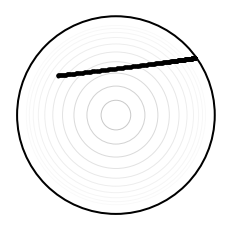

In [241]:
from matplotlib.patches import Circle

def poincare_axis(ax):
    ax.set_aspect(1.0)    
    ax.add_patch(Circle(xy=(0,0), radius=1.0, lw=2, edgecolor='black', facecolor='none'))
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)    
    
    
    h = Hyperbolic(c=1)
    
    x = np.array([0.0,0.0])
    for i in range(10):
        x = h.add(x, np.array([0.15,0]))                         
        ax.add_patch(Circle(xy=(0,0), radius=x[0], lw=1, edgecolor='black', facecolor='none', alpha=0.25*(1.0-x[0])))
       
        
    
    
    ax.axis("off")
    
    
fig, ax = plt.subplots(1)    
poincare_axis(ax)


x = np.array([-0.59,0.4])
dx = np.array([0.09, 0.01])*0.1
h = Hyperbolic(c=1)

for i in range(400):
    ax.plot(x[0], x[1], 'k.')
    x = h.add(x, dx)
    dx = dx - dx[::-1] * -0.0001
    
    